In [19]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from prettytable import PrettyTable

# detect key point
def sift_detect(img):
    sift = cv2.xfeatures2d.SIFT_create()
    return sift.detect(img,None)

# show image
def imshow(img, title=None, dpi=200):
    plt.figure(dpi=dpi)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.imshow(img[...,::-1])
    plt.show()

# Rotation without cropping
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return M,cv2.warpAffine(image, M, (nW, nH))

# Calculate the points that have been linearly transformed
def apply_matrix(M,point):
    point = np.array([point[0],point[1],1]).T
    M = np.vstack([M,[0,0,1]])
    res = M.dot(point)
    return (int(res[0]),int(res[1]))

# Statistically matched feature points
def count_matched_kp(kp_set,target_kp_set):
    d = [(i%3-1,j%3-1) for i in range(3) for j in range(3)]
    # d = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    count = 0
    for i in target_kp_set:
        for j in d:
            if (i[0]+j[0],i[1]+j[1]) in kp_set:
                count+=1
                break
    return count


In [20]:
class Stitcher:
    # Stitcher function
    def stitch(self, images, ratio=0.75, reprojThresh=4.0, showMatches=False):
        # input image
        (imageB, imageA) = images
        # Detect the SIFT key feature points of A and B images and compute the feature descriptors
        (kpsA, featuresA) = self.detectAndDescribe(imageA)
        (kpsB, featuresB) = self.detectAndDescribe(imageB)

        # Match all the feature points of two images and return the matching result
        M = self.matchKeypoints(kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh)

        # If the return result is null and there are no successfully matched feature points, exit the algorithm
        if M is None:
            return None

        # Otherwise, extract the matching result
        # H is the 3x3 perspective transformation matrix
        (matches, H, status) = M
        # Transform the perspective of image A. Result is the transformed image.
        result = cv2.warpPerspective(imageA, H, (imageA.shape[1] + imageB.shape[1], imageA.shape[0]))

        # mixture
        for r in range(result.shape[0]):
            left = 0
            for c in range(result.shape[1]//2):
                if result[r,c].any(): # overlap
                    if left == 0:
                        left = c
                    alpha = (c-left)/(result.shape[1]//2-left)
                    result[r,c] = imageB[r,c]*(1-alpha) + result[r,c]*alpha
                else:
                    result[r,c] = imageB[r,c]

        # Pass image B into the leftmost part of the result image.
#         result[0:imageB.shape[0], 0:imageB.shape[1]] = imageB

        # whether it needs to show image matches
        if showMatches:
            # Generate matching images
            vis = self.drawMatches(imageA, imageB, kpsA, kpsB, matches, status)
            # return result
            return (result, vis)

        # return result
        return result
    
    def detectAndDescribe(self, image):
        # Converting colour images to greyscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Creating a SIFT generator
        descriptor = cv2.xfeatures2d.SIFT_create()
        # Detect SIFT feature points and compute descriptors
        (kps, features) = descriptor.detectAndCompute(gray, None)

        # Converting results to NumPy arrays
        kps = np.float32([kp.pt for kp in kps])

        # Return the set of feature points, and the corresponding descriptive features
        return kps, features

    def matchKeypoints(self, kpsA, kpsB, featuresA, featuresB, ratio, reprojThresh):
        # Creating a violent matcher
        matcher = cv2.DescriptorMatcher_create("BruteForce")

        # Detecting SIFT feature matching pairs from A and B graphs using KNN, K=2
        rawMatches = matcher.knnMatch(featuresA, featuresB, 2)

        matches = []
        for m in rawMatches:
            # When the ratio of the closest distance to the next closest distance is less than the value of ratio, the matching pair is retained.
            if len(m) == 2 and m[0].distance < m[1].distance * ratio:
                # Stores the indexes of the two points in featuresA, featuresB
                matches.append((m[0].trainIdx, m[0].queryIdx))

        # When the filtered matched pairs are greater than 4, the perspective transformation matrix is computed
        if len(matches) > 4:
            # Get the coordinates of the points of the matched pair
            ptsA = np.float32([kpsA[i] for (_, i) in matches])
            ptsB = np.float32([kpsB[i] for (i, _) in matches])

            # Calculate the perspective transformation matrix
            (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC, reprojThresh)

            # return result
            return (matches, H, status)

        # Returns None if the number of matches is less than 4.
        return None
    
    def drawMatches(self, imageA, imageB, kpsA, kpsB, matches, status):
        # Initialise the visualisation picture, connecting A and B left and right together
        (hA, wA) = imageA.shape[:2]
        (hB, wB) = imageB.shape[:2]
        vis = np.zeros((max(hA, hB), wA + wB, 3), dtype="uint8")
        vis[0:hA, 0:wA] = imageA
        vis[0:hB, wA:] = imageB

        # Joint traversal, drawing matching pairs
        for ((trainIdx, queryIdx), s) in zip(matches, status):
            # When a point pair match is successful, it is drawn to the visualisation graph
            if s == 1:
                # Drawing matching pairs
                ptA = (int(kpsA[queryIdx][0]), int(kpsA[queryIdx][1]))
                ptB = (int(kpsB[trainIdx][0]) + wA, int(kpsB[trainIdx][1]))
                cv2.line(vis, ptA, ptB, (0, 255, 0), 1)

        # return result
        return vis


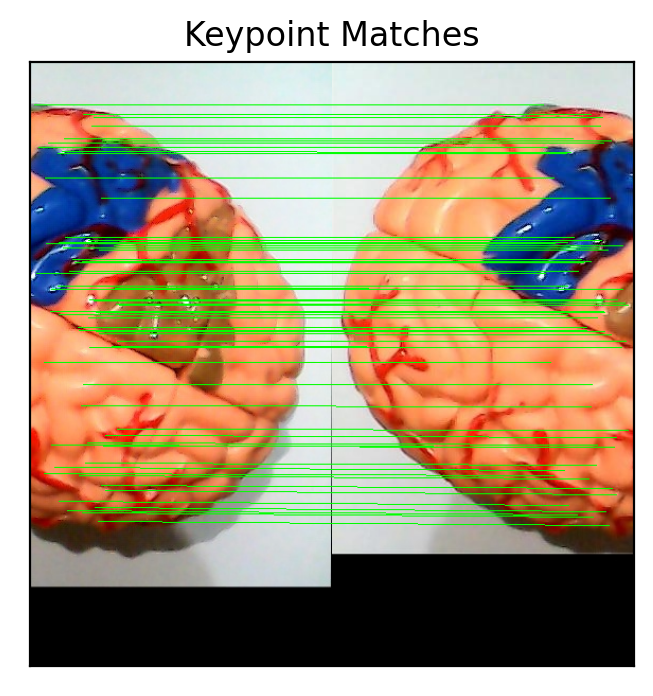

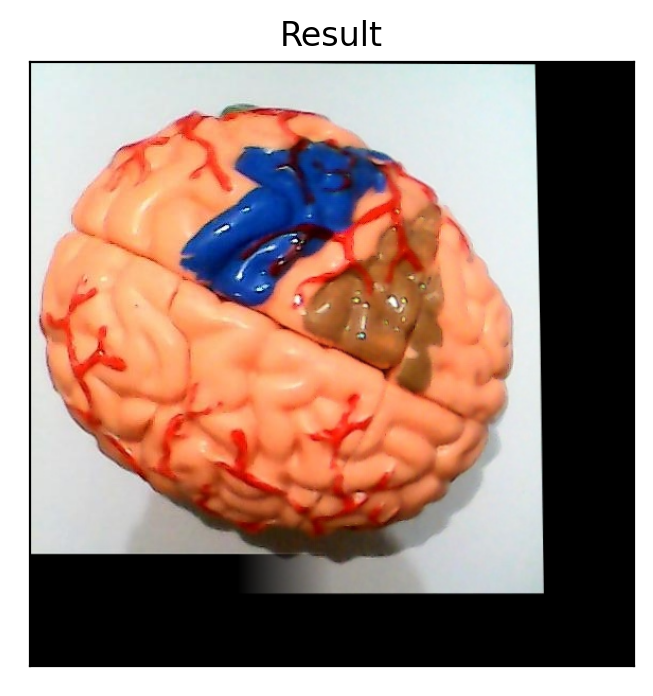

True

In [21]:
# read picture
imageA = cv2.imread("zsn2.jpg")
imageB = cv2.imread("zsn.jpg")

# stitch them
stitcher = Stitcher()
(result, vis) = stitcher.stitch([imageA, imageB], showMatches=True)

imshow(vis,title='Keypoint Matches',dpi=200)
imshow(result, title='Result',dpi=200)
cv2.imwrite('zsn3.jpg',result)
